In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_singlegrid_half'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f3c2fddfcc0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f3c2fec18d0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 83       |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 61 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.598       |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 42 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.618       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011162159 |
|    clip_fraction        | 0.319       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.784       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0672      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.027      |
|    std                  | 

policy iteration runtime: 42 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.645       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008712289 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.831       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0647      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.027      |
|    std                  | 0.0551      |
|    val

policy iteration runtime: 43 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.658        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060798465 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0627       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0282      |
|    std

policy iteration runtime: 42 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.667        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070369183 |
|    clip_fraction        | 0.341        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.874        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0489       |
|    n_updates            | 660          |
|    policy_gradient_loss | -0.0293      |
|    std

policy iteration runtime: 42 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.674        |
| time/                   |              |
|    fps                  | 189          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060708644 |
|    clip_fraction        | 0.343        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.882        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0554       |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.0288      |
|    std

policy iteration runtime: 44 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.68        |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009069431 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.894       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0592      |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0288     |
|    std                  |

policy iteration runtime: 46 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.685        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0059021264 |
|    clip_fraction        | 0.373        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.889        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0337       |
|    n_updates            | 1140         |
|    policy_gradient_loss | -0.0313      |
|    std

policy iteration runtime: 38 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006666851 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.897       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0808      |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0297     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 177         |
|    iterations           | 1           |
|    time_elapsed         | 14          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005177149 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0583      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0296     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 43 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 172         |
|    iterations           | 1           |
|    time_elapsed         | 14          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008625189 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.907       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0476      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0284     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 166         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009428081 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.909       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0338      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0309     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 47 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 163         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004807064 |
|    clip_fraction        | 0.385       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.9         |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0512      |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.0306     |
|    std                  |

policy iteration runtime: 44 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.012097624 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.909       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0724      |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0304     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 47 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.689      |
| time/                   |            |
|    fps                  | 162        |
|    iterations           | 1          |
|    time_elapsed         | 15         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00840348 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.9       |
|    explained_variance   | 0.903      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0632     |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.028     |
|    std                  | 0.055      |
|    value_loss           |

policy iteration runtime: 44 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 161         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008247999 |
|    clip_fraction        | 0.373       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.909       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0507      |
|    n_updates            | 2420        |
|    policy_gradient_loss | -0.0294     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0051503656 |
|    clip_fraction        | 0.367        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.908        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0783       |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.0291      |
|    std                  | 0.

policy iteration runtime: 44 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 161          |
|    iterations           | 1            |
|    time_elapsed         | 15           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0073775603 |
|    clip_fraction        | 0.379        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.914        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0352       |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.0294      |
|    std                  | 0.

policy iteration runtime: 44 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 156         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008399159 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.911       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0766      |
|    n_updates            | 2900        |
|    policy_gradient_loss | -0.0293     |
|    std                  | 0.0549      |
|    va

<IPython.core.display.Javascript object>


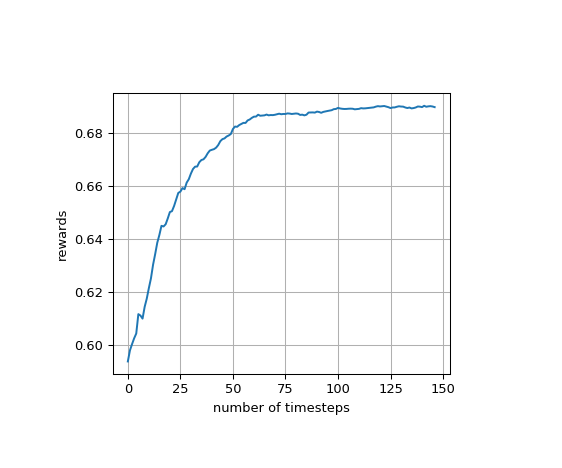

Using cuda device
seed 2: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f3c2fde8c50> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f3c2ff72ac8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.599       |
| time/                   |             |
|    fps                  | 85          |
|    iterations           | 1           |
|    time_elapsed         | 29          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005635646 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.9        |
|    explained_variance   | 0.91        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0599      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0284     |
|    std                  | 0.0549      |
|    value_loss           | 0.00309     |
------------

policy iteration runtime: 44 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.623       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 1           |
|    time_elapsed         | 15          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.013901937 |
|    clip_fraction        | 0.328       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.794       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.048       |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0263     |
|    std                  | 

policy iteration runtime: 47 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.645        |
| time/                   |              |
|    fps                  | 159          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0075450866 |
|    clip_fraction        | 0.347        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.843        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.084        |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0276      |
|    std 

policy iteration runtime: 45 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.665       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008559877 |
|    clip_fraction        | 0.338       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.857       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0705      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0268     |
|    std                  |

policy iteration runtime: 45 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.671        |
| time/                   |              |
|    fps                  | 156          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0037962527 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.87         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0597       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.029       |
|    std

policy iteration runtime: 45 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.677       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007780501 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.888       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.047       |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0294     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 45 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.682        |
| time/                   |              |
|    fps                  | 157          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068244725 |
|    clip_fraction        | 0.331        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.89         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.101        |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0277      |
|    std

policy iteration runtime: 48 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.686      |
| time/                   |            |
|    fps                  | 155        |
|    iterations           | 1          |
|    time_elapsed         | 16         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00623084 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.89       |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0273     |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0287    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 45 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.686        |
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0029577166 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.903        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0465       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.0291      |
|    std                  | 0.

policy iteration runtime: 49 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.688        |
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0039580883 |
|    clip_fraction        | 0.364        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.899        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0535       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.0289      |
|    std

policy iteration runtime: 46 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 153          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060477853 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.91         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0686       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0296      |
|    std                  | 0.

policy iteration runtime: 45 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006537816 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.912       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0489      |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0279     |
|    std                  |

policy iteration runtime: 48 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009165248 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.915       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0725      |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0288     |
|    std                  |

policy iteration runtime: 48 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008489278 |
|    clip_fraction        | 0.37        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.909       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.049       |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0295     |
|    std                  |

policy iteration runtime: 47 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.692      |
| time/                   |            |
|    fps                  | 153        |
|    iterations           | 1          |
|    time_elapsed         | 16         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00788745 |
|    clip_fraction        | 0.357      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.915      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0619     |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0281    |
|    std                  | 0.055      |
|    value_loss           |

policy iteration runtime: 46 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007850418 |
|    clip_fraction        | 0.369       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.913       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0484      |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0294     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 48 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.692       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 1           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004474717 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.917       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.103       |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0265     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 49 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.692        |
| time/                   |              |
|    fps                  | 152          |
|    iterations           | 1            |
|    time_elapsed         | 16           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0077756853 |
|    clip_fraction        | 0.385        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.917        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.069        |
|    n_updates            | 2720         |
|    policy_gradient_loss | -0.03        |
|    std                  | 0.

policy iteration runtime: 45 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.691      |
| time/                   |            |
|    fps                  | 154        |
|    iterations           | 1          |
|    time_elapsed         | 16         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00817815 |
|    clip_fraction        | 0.379      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.92       |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0574     |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0291    |
|    std                  | 0.055      |
|    value_loss           |

<IPython.core.display.Javascript object>


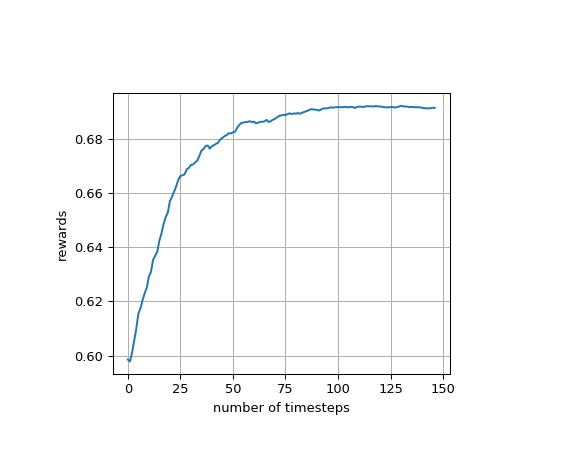

Using cuda device
seed 3: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f3c306b0828> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f3bcc042128>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.598       |
| time/                   |             |
|    fps                  | 92          |
|    iterations           | 1           |
|    time_elapsed         | 27          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008705894 |
|    clip_fraction        | 0.382       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.922       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0629      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.03       |
|    std                  | 0.055       |
|    value_loss           | 0.00281     |
------------

policy iteration runtime: 45 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.616       |
| time/                   |             |
|    fps                  | 181         |
|    iterations           | 1           |
|    time_elapsed         | 14          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009261787 |
|    clip_fraction        | 0.332       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.781       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0546      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0255     |
|    std                  | 

policy iteration runtime: 46 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.636        |
| time/                   |              |
|    fps                  | 183          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0057842196 |
|    clip_fraction        | 0.33         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.854        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0518       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0255      |
|    std 

policy iteration runtime: 45 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.654       |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010271912 |
|    clip_fraction        | 0.333       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.869       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0637      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0268     |
|    std                  |

policy iteration runtime: 44 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.667        |
| time/                   |              |
|    fps                  | 192          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056271167 |
|    clip_fraction        | 0.332        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.884        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0779       |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.0265      |
|    std

policy iteration runtime: 44 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.674       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011052039 |
|    clip_fraction        | 0.355       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.899       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0536      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0298     |
|    std                  |

policy iteration runtime: 45 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.682       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007625714 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.7        |
|    explained_variance   | 0.895       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0467      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0286     |
|    std                  |

policy iteration runtime: 44 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.684        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0072420924 |
|    clip_fraction        | 0.345        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.902        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0613       |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.0275      |
|    std                  | 0.

policy iteration runtime: 46 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.686        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0023272038 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.907        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0685       |
|    n_updates            | 1280         |
|    policy_gradient_loss | -0.029       |
|    std

policy iteration runtime: 44 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0043924274 |
|    clip_fraction        | 0.365        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.907        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0645       |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.029       |
|    std

policy iteration runtime: 46 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.687        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068179844 |
|    clip_fraction        | 0.337        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.7         |
|    explained_variance   | 0.905        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0744       |
|    n_updates            | 1600         |
|    policy_gradient_loss | -0.0273      |
|    std                  | 0.

policy iteration runtime: 44 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.688        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0068039806 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.913        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0646       |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.0293      |
|    std                  | 0.

policy iteration runtime: 43 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 190          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0091776755 |
|    clip_fraction        | 0.358        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.914        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0525       |
|    n_updates            | 1920         |
|    policy_gradient_loss | -0.0284      |
|    std                  | 0.

policy iteration runtime: 43 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.69         |
| time/                   |              |
|    fps                  | 187          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0056258785 |
|    clip_fraction        | 0.366        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.92         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0578       |
|    n_updates            | 2080         |
|    policy_gradient_loss | -0.0293      |
|    std

policy iteration runtime: 37 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006730479 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.919       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.081       |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0283     |
|    std                  |

policy iteration runtime: 42 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.691        |
| time/                   |              |
|    fps                  | 193          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0063899728 |
|    clip_fraction        | 0.355        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.919        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.037        |
|    n_updates            | 2400         |
|    policy_gradient_loss | -0.0275      |
|    std                  | 0.

policy iteration runtime: 46 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005468175 |
|    clip_fraction        | 0.374       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.923       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.066       |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.0289     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 42 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.691       |
| time/                   |             |
|    fps                  | 191         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005894497 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.929       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0446      |
|    n_updates            | 2720        |
|    policy_gradient_loss | -0.0277     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 43 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.691        |
| time/                   |              |
|    fps                  | 191          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0062473593 |
|    clip_fraction        | 0.378        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.922        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0602       |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.0288      |
|    std                  | 0.

<IPython.core.display.Javascript object>


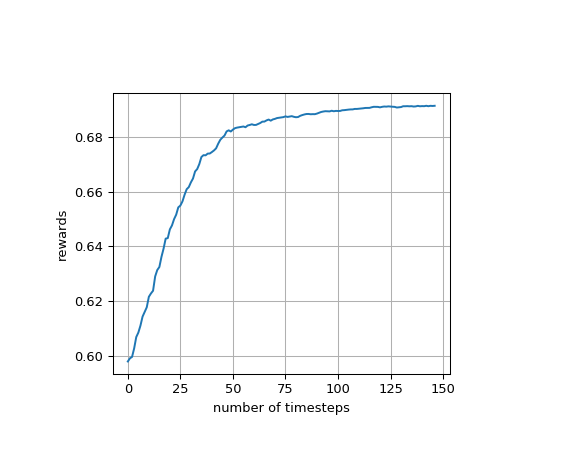

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.5],
                                episode_limit_array=[75000], 
                                log_dir=log_dir,
                                seed=seed)